In [1]:
# Import the packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import silhouette_score

In [ ]:
plt.style.use("bmh")
alph = 0.5

In [2]:
# Hide the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import custom functions
from helpers import *

In [4]:
#Import the data obtained after the 2nd milestone
data = pd.read_csv("./Milestone P2/Big_Cleaned_dataset.csv", index_col=0)
data.head(2)

,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Main_genre,Main_country
0,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",F,1.62,NaN,Wanda De Jesus,42.0,Thriller,United States of America
1,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",F,1.78,/m/044038p,Natasha Henstridge,27.0,Thriller,United States of America


# 1.Dataset additional treatment

We realized that some values must be treated again :
- The sizes must be scaled because women are generally smaller than men
- The box office revenues must be scaled because of the inflation
- We need to associate a region to a country for spatial analysis
- We have to reduce the number of genres by doing some clustering

In [5]:
label = ["Actor_gender_male"]

#Later on, we would like to rename some columns in the dataset
col2rename = {"Actor_gender":label[0], "Movie_box_office_revenue":"Movie_box_office_scaled", "Actor_height_m":"Actor_height_scaled"}

#Define the numerical and categorical features after renaming
numerical_features = ["Movie_release_date", "Movie_box_office_scaled", "Movie_runtime",
                      "Actor_age_at_movie_release", "Actor_height_scaled"]
categorical_features = ["Cluster_Name", "Region"]

## 1.1 Associating Regions

In [6]:
#Check how many countries we have
data['Main_country'].value_counts()

Main_country
United States of America    134089
India                        14376
France                        9734
United Kingdom                9557
Japan                         5788
                             ...  
Armenia                          1
Nigeria                          1
Palestinian territories          1
Bhutan                           1
Algeria                          1
Name: count, Length: 103, dtype: int64

In [7]:
#Associate a region to each country
data["Region"] = data["Main_country"].copy().apply(country_to_region)
data["Region"].value_counts()

Region
North America    136883
West Europa       31159
Asia              25106
East Europa        2795
Oceania            2027
South America       696
Dead country        402
Africa              218
Name: count, dtype: int64

In [8]:
#Verify if we didn't forget any country
data[data["Region"]=="Unknown region"]["Main_country"].unique()

array([], dtype=object)

## 1.2 Clustering

In [9]:
data['Movie_genres'] = data['Movie_genres'].apply(string2dict)
df2 = data.drop_duplicates(subset='Movie_name', inplace=False)

In [10]:
all_genres = df2['Movie_genres'].explode()

genre_counts = all_genres.value_counts() #type series
print(genre_counts.sum()) #length 293 genres différents

prop_genre = genre_counts/genre_counts.sum()
#print(prop_genre)

cum_prop_genre = prop_genre.cumsum()
#print(cum_prop_genre)

genre_95 = cum_prop_genre[cum_prop_genre<=0.50]

#print(genre_95.index)

print(genre_counts[genre_95.index])
print(genre_counts[genre_95.index].sum())
print(len(genre_95.index))

111029
Movie_genres
Drama              14216
Comedy              8442
Romance Film        4963
Black-and-white     4652
Thriller            4344
Action              4079
Indie               3530
Crime Fiction       3212
World cinema        2823
Short Film          2749
Name: count, dtype: int64
53010
10


In [11]:
MLB = MultiLabelBinarizer()
genres_matrix = MLB.fit_transform(df2['Movie_genres'])
print(f"There are {genres_matrix.shape[1]} genres") # il y'a 293 différents genres

There are 343 genres


In [12]:
genres_df = pd.DataFrame(genres_matrix, columns=MLB.classes_, index=df2['Movie_name']) #convertit la mtrice en df
df_film_genres = genres_df[genre_95.index]
df_film_genres.head()

,Drama,Comedy,Romance Film,Black-and-white,Thriller,Action,Indie,Crime Fiction,World cinema,Short Film
Movie_name,,,,,,,,,,
Ghosts of Mars,0,0,0,0,1,1,0,0,0,0
Getting Away with Murder: The JonBenét Ramsey Mystery,1,0,0,0,0,0,0,0,0,0
The Gangsters,0,1,0,1,0,0,1,0,0,1
Alexander's Ragtime Band,0,1,0,1,0,0,0,0,0,0
Little city,1,1,1,0,0,0,0,0,0,0


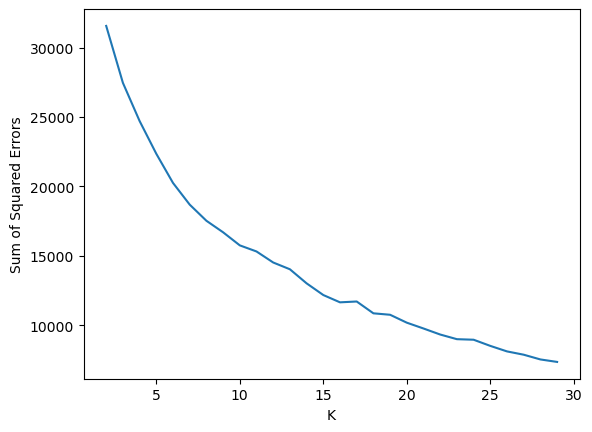

<Axes: xlabel='K', ylabel='Sum of Squared Errors'>

In [13]:
plot_sse(df_film_genres, start=2, end=30) #nous permet d'identifier que 10 c'est top ! 

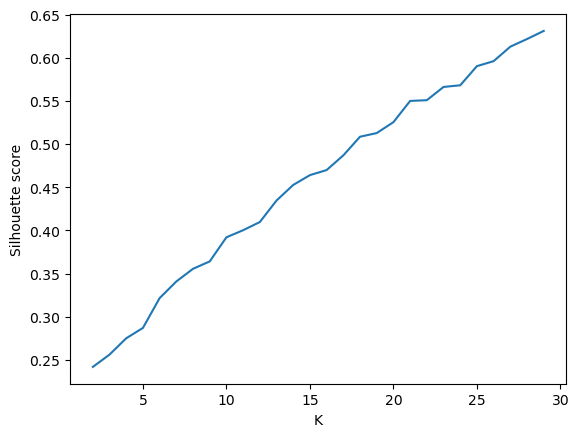

In [14]:
silhouettes = []
# Try multiple k
for k in range(2, 30):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(df_film_genres)
    # Get the Silhouette score
    score = silhouette_score(df_film_genres, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.show()

In [15]:
kmeans = KMeans(n_clusters=15, random_state=42)
df_film_genres['Cluster'] = kmeans.fit_predict(df_film_genres)
print(f"Reduced genres to {df_film_genres.shape[1]}")

Reduced to 11


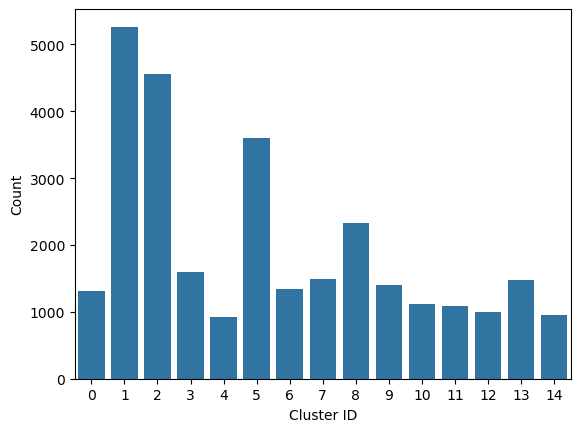

In [ ]:
cluster_counts = df_film_genres['Cluster'].value_counts()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster ID')
plt.ylabel('Count of movies')
plt.title('Movie distribution for each cluster')
plt.show()

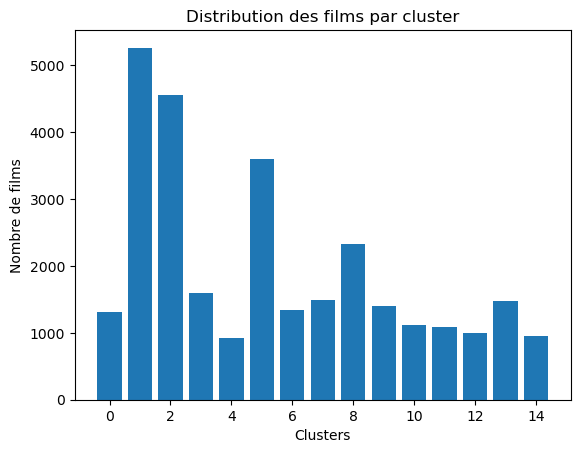

In [18]:
cluster_names = {}

for cluster_id in np.unique(kmeans.labels_):
    print(cluster_id)
    cluster_films = df_film_genres[df_film_genres['Cluster'] == cluster_id].drop(columns=['Cluster'])
    genre_sum = cluster_films.sum()
    top_genres = genre_sum.sort_values(ascending=False).head(5)
    print(top_genres)
    
## By counting and printing how much each genres appears in each cluster, 
# we are able to name the clusters by hand. This is done below

cluster_names = {
    0: "Comedy - Short film",
    1: "Drama - Thriller",
    2: "Short film - World cinema",
    3: "Crime - Thriller",
    4: "Drama - Comedy",
    5: "Comedy - Action",
    6: "Drama",
    7: "Drama - Romance",
    8: "Action - Thriller",
    9: "Drama - Indie",
    10: "B&W - Indie",
    11: "Drama - B&W",
    12: "Drama - Comedy",
    13: "Romance - Comedy",
    14: "Thriller"
}

0
Comedy             1319
Short Film         1273
Black-and-white    1009
Indie               701
Drama                10
dtype: int64
1
Drama            5265
Thriller          487
Crime Fiction     426
Short Film        125
Comedy              0
dtype: int64
2
Short Film       549
World cinema     251
Crime Fiction    209
Indie            167
Drama              0
dtype: int64
3
Crime Fiction    1592
Thriller         1472
Drama            1111
Action            693
World cinema      180
dtype: int64
4
Drama           922
Comedy          922
Romance Film    922
World cinema    222
Indie           167
dtype: int64
5
Comedy             3606
Action              449
Black-and-white     363
Crime Fiction       255
Indie               236
dtype: int64
6
World cinema    1343
Drama           1336
Romance Film     556
Thriller         162
Action           114
dtype: int64
7
Drama              1498
Romance Film       1498
Black-and-white     164
Action              146
Crime Fiction        98
dty

In [19]:
df_film_genres['Cluster_Name'] = df_film_genres['Cluster'].map(cluster_names)
df_film_genres.head()

,Drama,Comedy,Romance Film,Black-and-white,Thriller,Action,Indie,Crime Fiction,World cinema,Short Film,Cluster,Cluster_Name
Movie_name,,,,,,,,,,,,
Ghosts of Mars,0,0,0,0,1,1,0,0,0,0,8,Action - Thriller
Getting Away with Murder: The JonBenét Ramsey Mystery,1,0,0,0,0,0,0,0,0,0,1,Drama - Thriller
The Gangsters,0,1,0,1,0,0,1,0,0,1,0,Comedy - Short film
Alexander's Ragtime Band,0,1,0,1,0,0,0,0,0,0,5,Comedy - Action
Little city,1,1,1,0,0,0,0,0,0,0,4,Drama - Comedy


In [20]:
df = data.merge(df_film_genres[['Cluster', 'Cluster_Name']], left_on='Movie_name', right_index=True, how='left')

df.head()

,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Main_genre,Main_country,Region,Cluster,Cluster_Name
0,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",F,1.620,NaN,Wanda De Jesus,42.0,Thriller,United States of America,North America,8,Action - Thriller
1,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",F,1.780,/m/044038p,Natasha Henstridge,27.0,Thriller,United States of America,North America,8,Action - Thriller
2,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",M,1.727,/m/0x67,Ice Cube,32.0,Thriller,United States of America,North America,8,Action - Thriller
3,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",M,1.750,NaN,Jason Statham,33.0,Thriller,United States of America,North America,8,Action - Thriller
4,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",F,1.650,NaN,Clea DuVall,23.0,Thriller,United States of America,North America,8,Action - Thriller


## 1.3 Encode the gender, Scale the size and the box office

### 1.3.1 Encoding the gender

In [22]:
#Delete the rows that have a "Unknown" gender which is useless for our analysis
df = df.query("Actor_gender != 'Unknown' ")

#One-hot encoding for the label(gender)
df["Actor_gender"] = df["Actor_gender"].apply(lambda x: 1 if x=="M" else 0)

df = df.rename(columns=col2rename)

### 1.3.2 Scaling the size

In [23]:
#Scale the actor height: we create a ratio of size for each gender based on their mean height
mean_height_male = 1.7429 #m
mean_height_female = 1.57 #m

df['Actor_height_scaled'] = df['Actor_height_scaled']/mean_height_male * (df[label[0]] == 1) + df['Actor_height_scaled']/mean_height_female * (df[label[0]] != 1)

### 1.3.3 Scaling the box office

In [26]:
#Scale the box office revenue based on the inflation
df_CPI = pd.read_csv("./additional_datasets/CPI.csv") # dataset with the CPI of the dollard for the years of interest based on the year 1984
base = 100 # corrspond to 1984
df_CPI['year'] = pd.to_datetime(df_CPI['observation_date'], errors='coerce').dt.year
df = pd.merge(df, df_CPI, left_on = 'Movie_release_date', right_on= 'year', how = 'left') # associate the CPI with the movie year release
df["Movie_box_office_scaled"] = df["Movie_box_office_scaled"] / df["CPIAUCNS"] * base

## 1.4 Deleting, Standardizing, Encoding and Exporting the data

To gain some time, we export the data into 3 CSV files: 
- **`data_cleaned_countries`**: contains the box office, the date, the country and the region
- **`data_cleaned.csv`**: 
- **`data_cleaned_standardized`**: the previous dataset, but with the standardized numerical features

### 1.4.1 Deleting useless columns

In [27]:
#Delete all columns that we do not care
## For spatial analysis
df_countries = df.drop(columns=[col for col in df.columns if col not in 
                                  ["Movie_name","Movie_release_date","Movie_box_office_scaled","Actor_gender_male",
                                   "Main_country", "Region", "Actor_name"]])

## For the others
df = df.drop(columns=[col for col in df.columns if col not in 
                        (numerical_features + categorical_features + label + ["Movie_name"] + ["Actor_name"])])

### 1.4.2 One-hot encoding and standardization

In [28]:
#One-hot encoding for the categorical features (genre, region)
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

#Standardization of the data
df_std = df.copy()
df_std[[col for col in df.columns if col in numerical_features]] = StandardScaler().fit_transform(
                                                        df[[col for col in df.columns if col in numerical_features]])

### 1.4.3 Exporting

In [ ]:
df.to_csv("./data/data_cleaned.csv")
df_std.to_csv("./data/data_cleaned_standardized.csv")
df_countries.to_csv("./data/data_cleaned_countries.csv")

From now on, we will restart the data analysis from scratch, assuming that we only have the post-processing data files.

# 2. Spatial analysis

In [ ]:
#Import the data
df_countries = pd.read_csv("data_cleaned_countries.csv", index_col=0)

# 3. Bias analysis

In [ ]:
df = pd.read_csv("./data/data_cleaned.csv", index_col=0)
df_std = pd.read_csv("./data/data_cleaned_standardized.csv", index_col=0)

# 4. Matching the data